# L2 snapshots fast sampling phase 

In [2]:
import os, sys

import numpy as np
import pandas as pd
import xarray as xr
import datetime

import matplotlib.pyplot as plt
import cartopy
crs = cartopy.crs.PlateCarree()
import cartopy.feature as cfeature

import hvplot.xarray
import hvplot.pandas

#import pyinterp

#import dask_jobqueue
#import dask
#from distributed import Client

sys.path.append("/work/HELPDESK_SWOTLR/swot_diego/libs")
import swot_diego as sd

---

## utils

In [3]:
# L2

def plot_l2(D, v, pass_number, cycle_number, mask_threshold=1, figsize=(10,10), lat_bounds=None, cmap=None, **kwargs):

    fig, ax = plt.subplots(1,1, figsize=figsize)

    #v, vmin, vmax, cmap = "ssh_karin_2", -.2, .2, "seismic_r"
    #v, vmin, vmax, cmap = "sig0_karin_2", 0.5, None, "Greys_r"

    for side, ds in D.items():

        if lat_bounds is not None:
            ds = ds.where( (ds.latitude>lat_bounds[0]) & (ds.latitude<lat_bounds[1]), drop=True)
        
        da = ds[v]
        if v=="ssh_karin_2":
            da = da - ds["mean_sea_surface_cnescls"]
            da = da - da.median("num_lines") # in lieu of cross-over correction
            cmap = "seismic_r"
        if v=="sig0_karin_2":
            #da = np.log10(da)
            da = da/da.median()
            cmap = "Greys_r"
        if mask_threshold:
            mask = (ds[v+"_qual"]<mask_threshold)
            da = da.where(mask)

        dkwargs = dict(s=.1, cmap=cmap)
        dkwargs.update(**kwargs)
        im = ax.scatter(ds.longitude, ds.latitude, c=da, **dkwargs)

    fig.colorbar(im, ax=ax)
    
    t = D["left"].time.mean().values
    ax.set_title(f"pass={pass_number}, cycle={cycle_number}, t={t}")
    ax.set_aspect(1/np.cos(np.pi/180*ds.latitude.mean().values))

def add_filtered_fields(ds):

    # ssh_karin_2
    v = "ssh_karin_2"
    da = ds[v] - ds["mean_sea_surface_cnescls"] # ssh specific    
    da_high, da_low = clean_heuristic(da)
    ds[v+"_low"] = da_low
    ds[v+"_high"] = da_high
    
    # sigma0
    v = "sig0_karin_2"
    da = ds[v]/ds[v].median() # sig0 specific
    da_high, da_low = clean_heuristic(da, vmax=None)
    ds[v+"_low"] = da_low
    ds[v+"_high"] = da_high
    
    return ds

def clean_heuristic(da, vmax=1):

    # crude treatment of systematic errors
    #da = da - da.median("num_lines") 
    n = int(20e3/250)
    da_low = da.rolling(num_lines=n, center=True).median() #.interpolate_na("num_lines")
    da_high = da-da_low
    # first pass at eliminating bad pixels:
    if vmax:
        da = da.where(np.abs(da) < vmax)
    # get rid of remaining isolated bad pixels by spreading them with a rolling operation
    #da = da.rolling(dict(num_lines=3,num_pixels=3), center=True).mean()
    # store mask?
    #mask = xr.where( np.isnan(da), 0, 1)

    return da_high, da_low
    
def clean_convolution(da):
    
    from scipy.signal import convolve2d
    from scipy.ndimage import convolve

    lbd = 20e3 # m
    dx = 250
    n = int(lbd/dx*1.5)
    #print(f"n={n}")
    x, y = (np.arange(-n,n)*dx,)*2
    kernel = np.exp( - (x[:, None]**2 + x[None,:]**2)/lbd**2 )
    kernel = kernel/kernel.sum()
    #print("kernel shape: ", kernel.shape)

    def detrend(da):
        fit = da.polyfit("num_lines", 1)
        da_out = xr.polyval(coord=da.num_lines, coeffs=fit["polyfit_coefficients"])
        #da_out = da_out.rename(da.name+"_detrended")
        return da_out
    
    # detrend
    #da = da - detrend(da)
    # fill NaNs
    da = (
        da
        .interpolate_na("num_lines", method="nearest", fill_value="extrapolate")
        .interpolate_na("num_pixels", method="nearest", fill_value="extrapolate")
    )
    
    # !! should fill in bad values first
    da_low = xr.DataArray(convolve2d(da.values, kernel, mode="same", boundary="symm"), da.coords)
    da_high = da - da_low
    
    return da_high, da_low
    

# wind

def show_wind_teries(era5):

    fig, ax = plt.subplots(1,1, figsize=(10,4))
    era5["wind_speed"].plot(ax=ax, color="k", lw=3, label="wind speed")
    era5["u10"].plot(ax=ax, label="eastward")
    era5["v10"].plot(ax=ax, label="northward")
    #ax.axvline(t, color="k", lw=3)
    ax.grid()
    ax.legend()
    ax.set_ylabel("[m/s]")
    ax.set_title(region)
    

def get_wind_hist(era5, bins):
    h, xb, yb = np.histogram2d(era5["u10"], era5["v10"], bins=bins, density=True)
    xc, yc = (xb[:-1]+xb[1:])*.5, (yb[:-1]+yb[1:])*.5

    ds = xr.Dataset(dict(h=(("y","x"), h.T)), coords=dict(x=("x", xc), y=("y", yc)))
    ds = ds.rename(x="u10", y="v10")
    return ds["h"]


def show_wind_hist(era5, bins_speed, bins):
            
    # wind speed
    fig, ax = plt.subplots(1,1, figsize=(5,3))
    era5["wind_speed"].plot.hist(ax=ax, bins=bins_speed, color="k", lw=3, label="wind speed")
    ax.grid()
    ax.legend()
    ax.set_ylabel("")
    ax.set_xlabel("[m/s]")
    ax.set_title(region)    

    
    # polar plot histogram
    h = get_wind_hist(era5, bins)

    fig = plt.figure(figsize=(5,5))

    ax = fig.add_subplot()
    axp = fig.add_axes(ax.get_position().bounds, polar=True, frameon=False)

    h.plot(ax=ax, cmap="Greys", add_colorbar=False)

    rmax = bins[-1]
    ax.set_aspect('equal')
    ax.set_xlim(-rmax,rmax)
    ax.set_ylim(-rmax,rmax)
    axp.set_rlim(0,rmax)
    ax.axis("off")
    
def plot_wind_tseries_small(era5):
    fig, ax = plt.subplots(1,1)
    era5["wind_speed"].plot(ax=ax, color="k", lw=3, label="wind speed")
    era5["u10"].plot(ax=ax, label="u10")
    era5["v10"].plot(ax=ax, label="v10")
    ax.axvline(t, color="k", lw=3)
    ax.grid()
    ax.legend()
    ax.set_ylabel("[m/s]")
    ax.set_title("")    

---

## Mediterranean area

In [3]:
list(sd.regions)

['med_NW', 'med_NW_CN', 'mascarene', 'amazone']

In [4]:
region = "med_NW_CN"
info = sd.regions[region]

# load wind
location = info["location"]
era5 = sd.load_era5("2023/04/01", "2023/07/15", location=location)

times = sd.get_times(info["coordinates"])

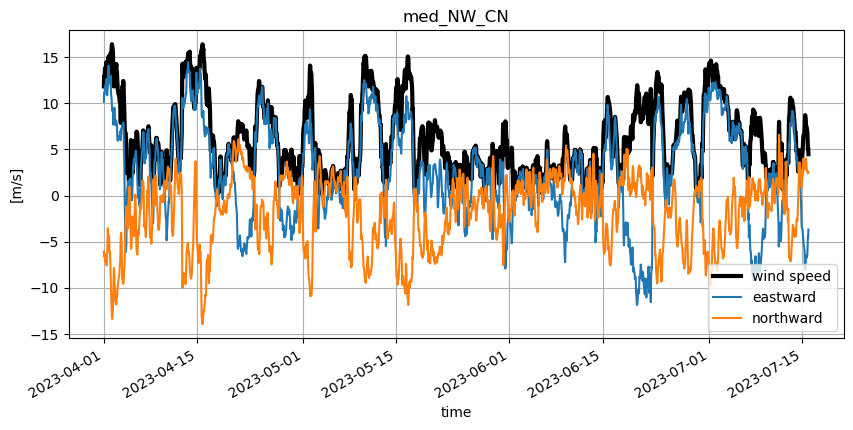

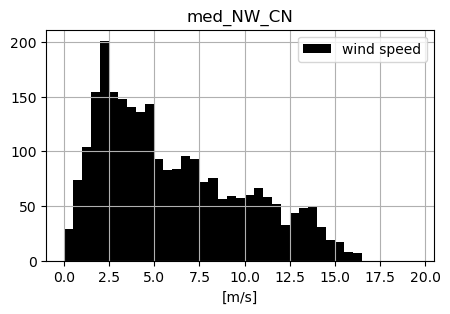

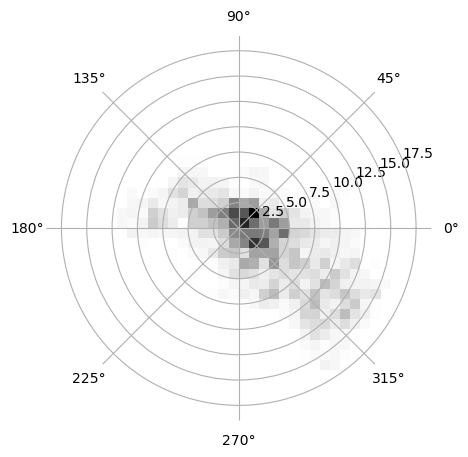

In [5]:
# show wind statistics
show_wind_teries(era5)
show_wind_hist(era5, np.arange(0,20,.5), np.arange(-20,20,1))

In [6]:
(era5["wind_speed"].hvplot(grid=True)*era5["u10"].hvplot()*era5["v10"].hvplot())

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.I   :Curve   [time]   (wind_speed)
   .Curve.II  :Curve   [time]   (u10)
   .Curve.III :Curve   [time]   (v10)

In [7]:
times.set_index("time")["cycle"].hvplot(grid=True)

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Curve   [time]   (cycle)

## load cycles and plot

variables: time / time_tai / latitude_uncert / longitude_uncert / polarization_karin / ssh_karin_2 / ssh_karin_2_qual / ssh_karin_uncert / sig0_karin_2 / sig0_karin_2_qual / sig0_karin_uncert / total_coherence / mean_sea_surface_cnescls / miti_power_250m / miti_power_var_250m / ancillary_surface_classification_flag


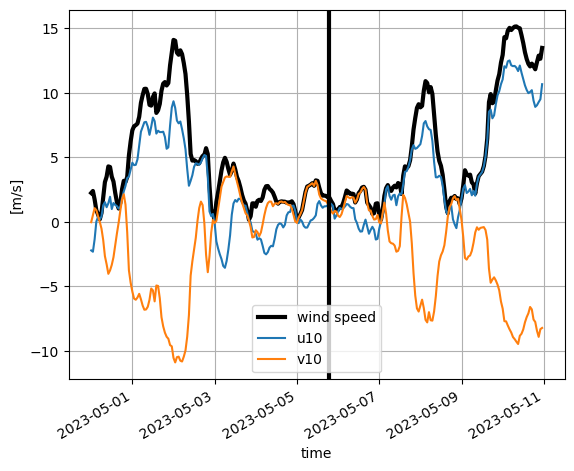

In [8]:
cycle_number = 512
pass_number = info["passes"][0]

D = sd.load_l2_core("Unsmoothed", pass_number, cycle_number, extent=info["extent"])
t = D["left"].time.mean().values
print("variables: "+" / ".join(list(D["left"])))

delta = pd.Timedelta("5d")
_era5 = sd.load_era5(t-delta, t+delta, location=info["location"])

plot_wind_tseries_small(_era5)

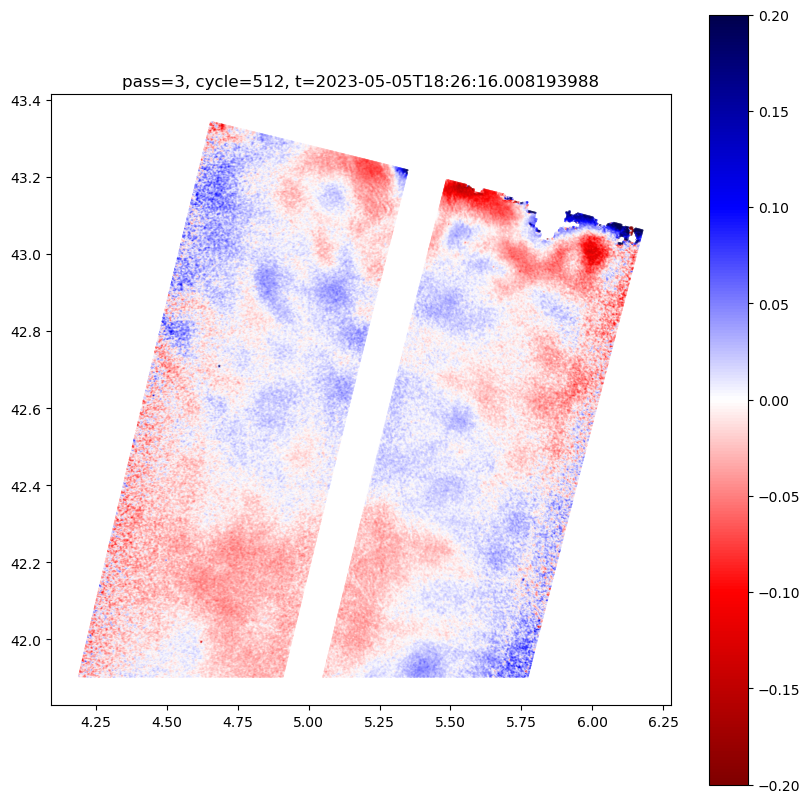

In [9]:
plot_l2(D, "ssh_karin_2", pass_number, cycle_number, mask_threshold=1, vmin=-.2, vmax=.2)

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


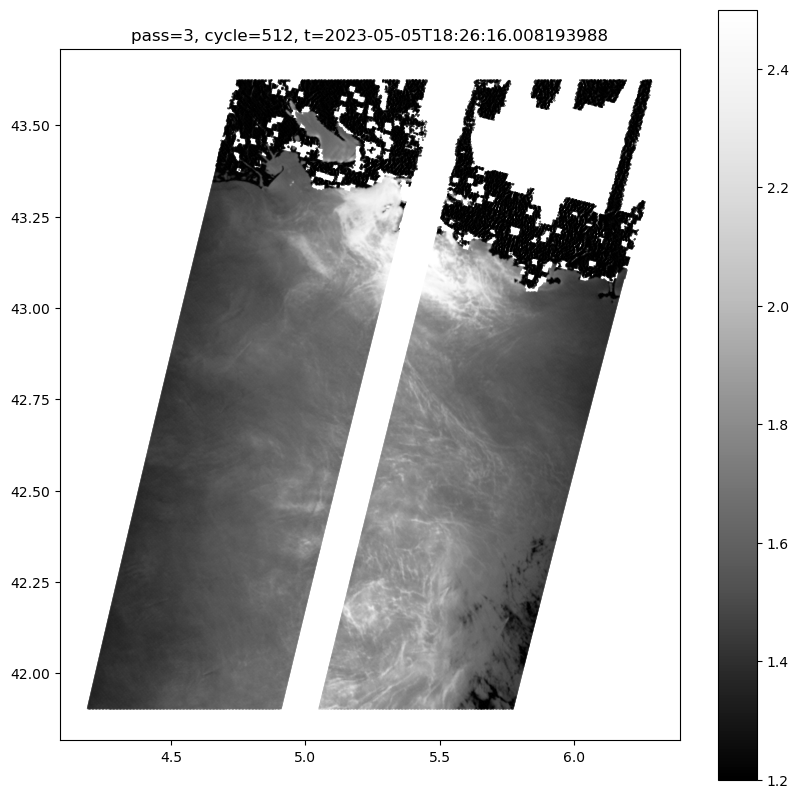

In [10]:
plot_l2(D, "sig0_karin_2", pass_number, cycle_number, mask_threshold=20, vmin=1.2, vmax=2.5)

---

## Mascarene Ridge

In [3]:
region = "mascarene"
info = sd.regions[region]

# load wind
location = info["location"]
era5 = sd.load_era5("2023/04/01", "2023/07/15", location=location)

times = sd.get_times(info["coordinates"])

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44399 instead
  warnings.warn(


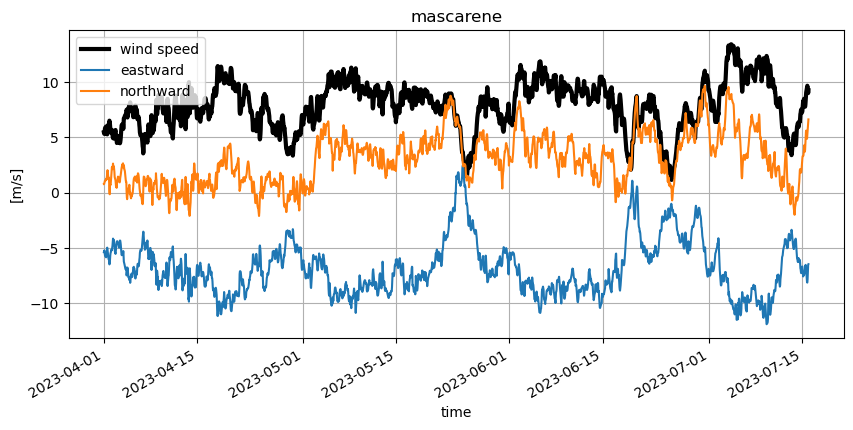

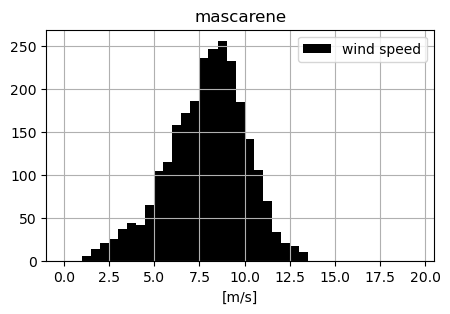

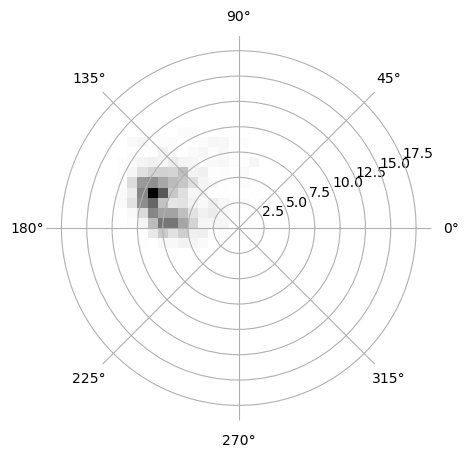

In [4]:
# show wind statistics
show_wind_teries(era5)
show_wind_hist(era5, np.arange(0,20,.5), np.arange(-20,20,1))

In [5]:
(era5["wind_speed"].hvplot(grid=True)*era5["u10"].hvplot()*era5["v10"].hvplot())

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.I   :Curve   [time]   (wind_speed)
   .Curve.II  :Curve   [time]   (u10)
   .Curve.III :Curve   [time]   (v10)

In [6]:
times.set_index("time")["cycle"].hvplot(grid=True)

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Curve   [time]   (cycle)

variables: time / time_tai / latitude_uncert / longitude_uncert / polarization_karin / ssh_karin_2 / ssh_karin_2_qual / ssh_karin_uncert / sig0_karin_2 / sig0_karin_2_qual / sig0_karin_uncert / total_coherence / mean_sea_surface_cnescls / miti_power_250m / miti_power_var_250m / ancillary_surface_classification_flag / ssh_karin_2_detrended / ssh_karin_2_low / ssh_karin_2_high


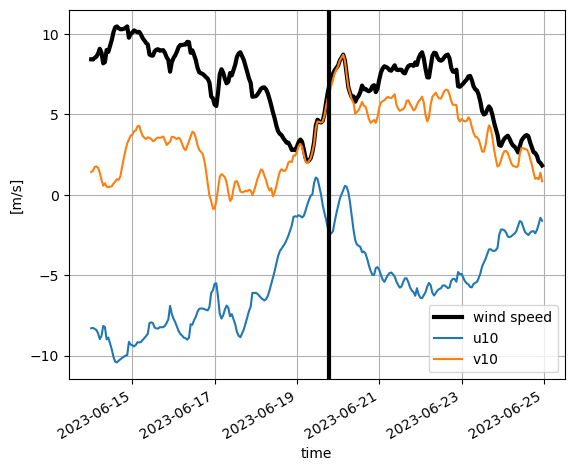

In [9]:
cycle_number = 532
cycle_number = 557
pass_number = info["passes"][0]

D = sd.load_l2_core(
    "Unsmoothed", pass_number, cycle_number, 
    extent=info["extent"],
    preprocessing=add_filtered_fields,
)
t = D["left"].time.mean().values
print("variables: "+" / ".join(list(D["left"])))

delta = pd.Timedelta("5d")
_era5 = sd.load_era5(t-delta, t+delta, location=info["location"])

plot_wind_tseries_small(_era5)

In [8]:
#plt.imshow(kernel)
#plt.colorbar()

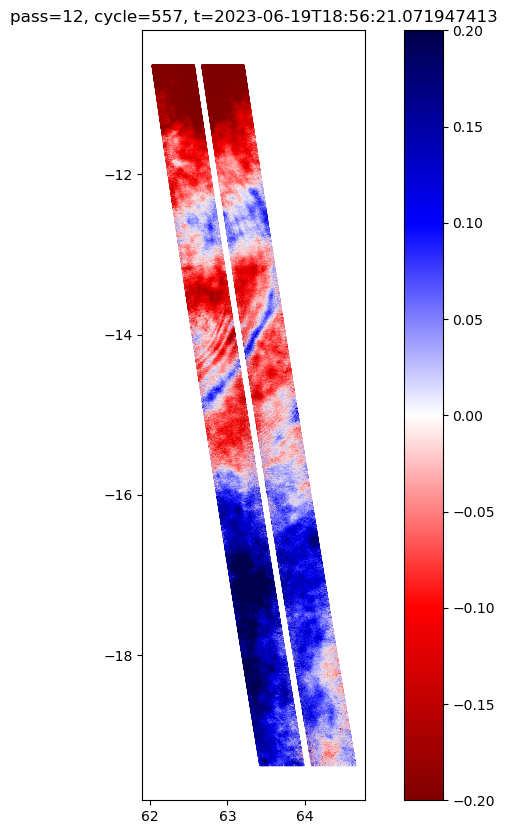

In [10]:
plot_l2(D, "ssh_karin_2", pass_number, cycle_number, mask_threshold=1, vmin=-.2, vmax=.2)

In [ ]:
#plot_l2(D, "ssh_karin_2_high", pass_number, cycle_number, mask_threshold=1, vmin=-.2, vmax=.2)

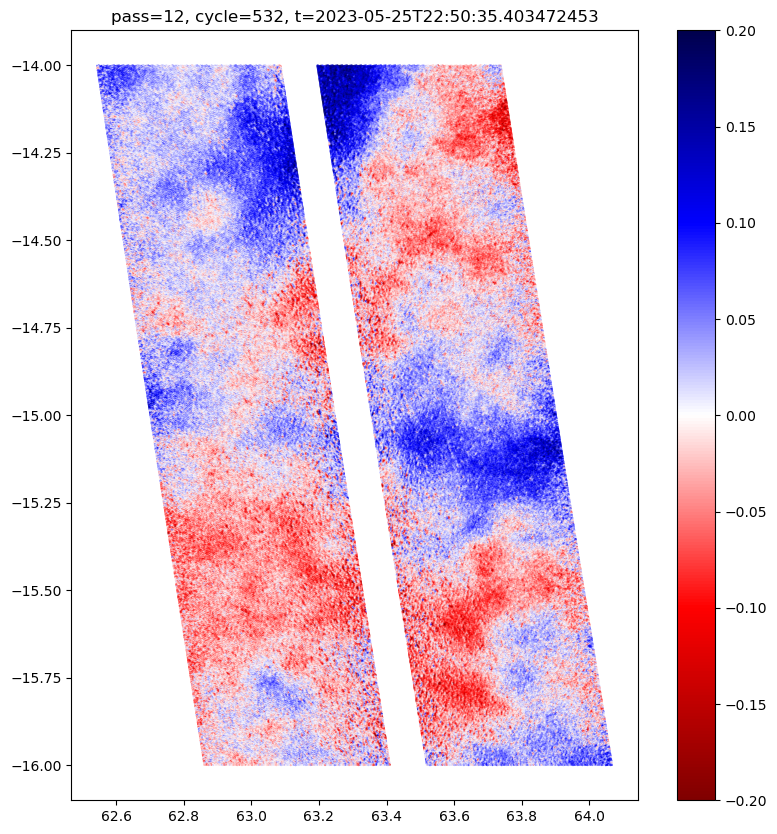

In [17]:
plot_l2(D, "ssh_karin_2", pass_number, cycle_number, mask_threshold=1, vmin=-.2, vmax=.2, lat_bounds=[-16,-14])

In [ ]:
plot_l2(D, "sig0_karin_2", pass_number, cycle_number, mask_threshold=20, vmin=1., vmax=2.)

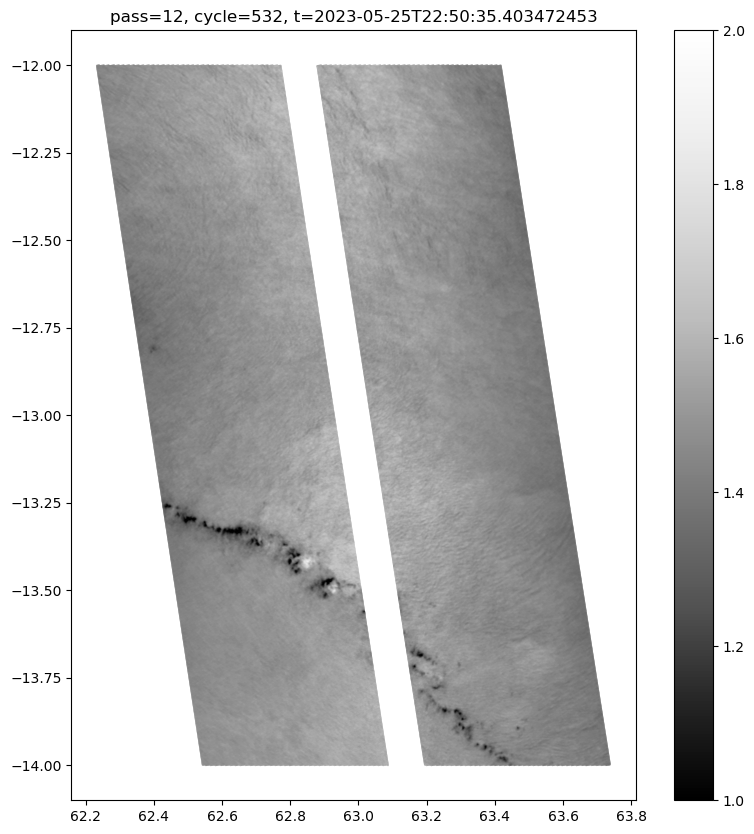

In [19]:
plot_l2(D, "sig0_karin_2", pass_number, cycle_number, mask_threshold=20, vmin=1., vmax=2., lat_bounds=[-14,-12])

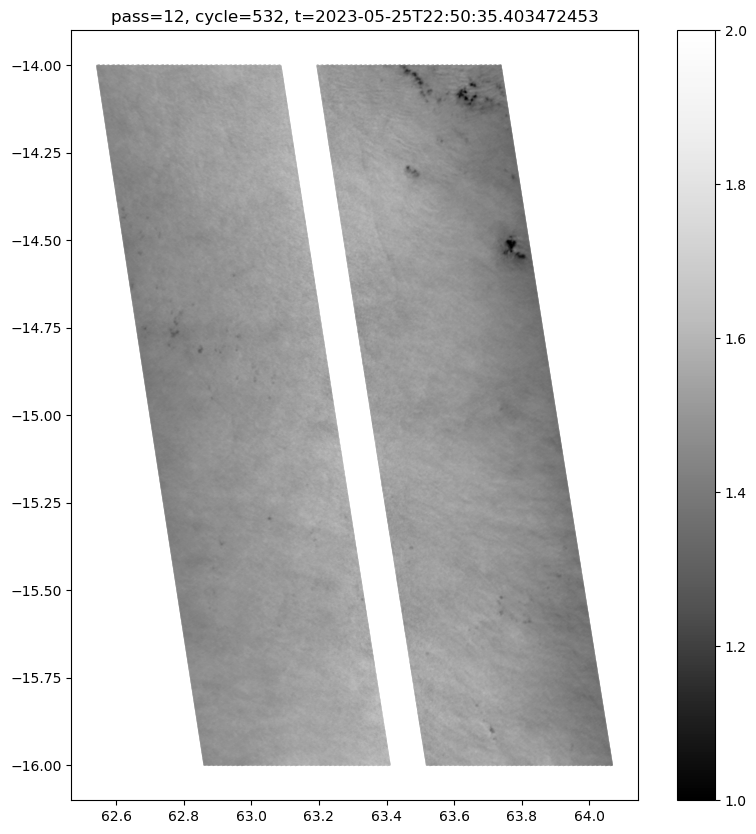

In [20]:
plot_l2(D, "sig0_karin_2", pass_number, cycle_number, mask_threshold=20, vmin=1., vmax=2., lat_bounds=[-16,-14])

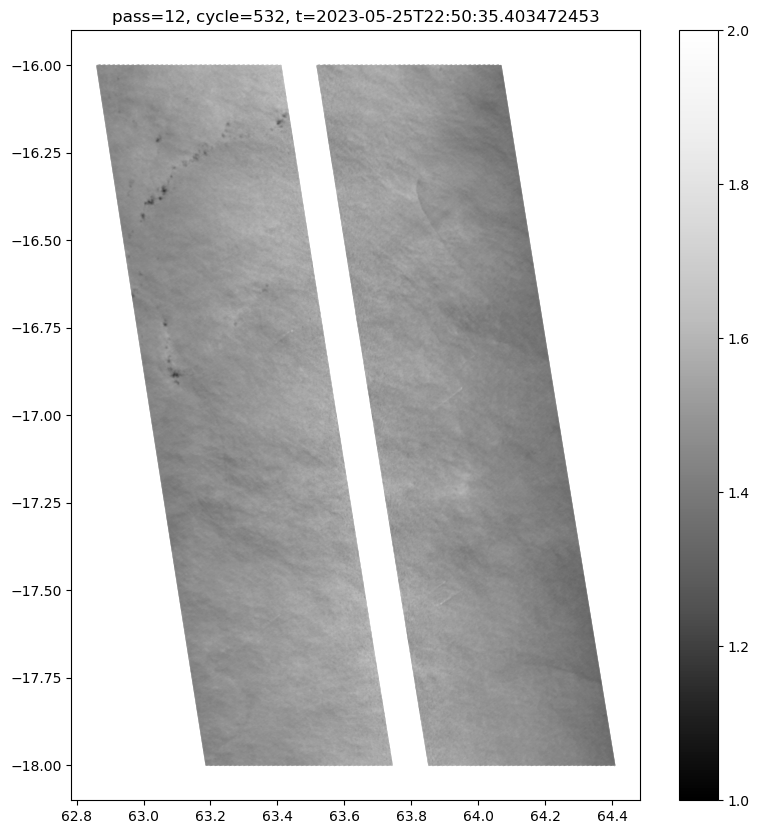

In [21]:
plot_l2(D, "sig0_karin_2", pass_number, cycle_number, mask_threshold=20, vmin=1., vmax=2., lat_bounds=[-18,-16])

---

## amazon

In [22]:
region = "amazone"
info = sd.regions[region]

# load wind
location = info["location"]
era5 = sd.load_era5("2023/04/01", "2023/07/15", location=location)

times = sd.get_times(info["coordinates"])

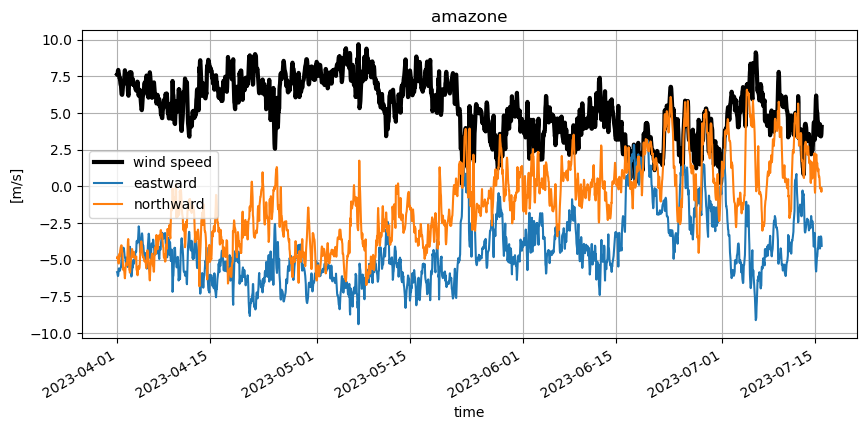

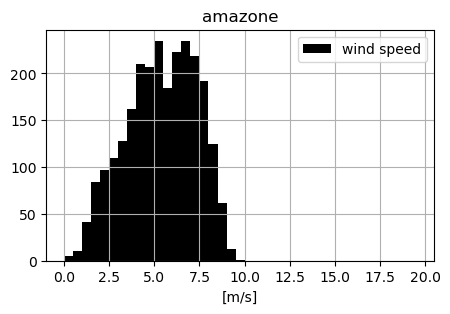

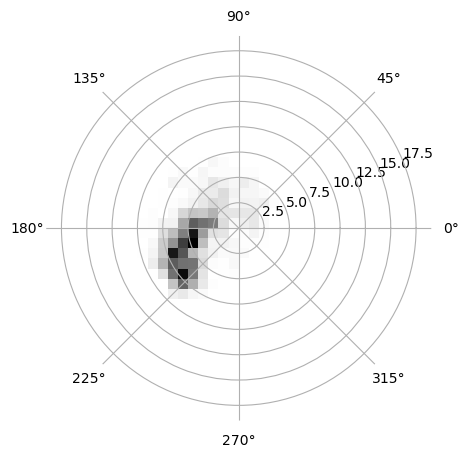

In [23]:
# show wind statistics
show_wind_teries(era5)
show_wind_hist(era5, np.arange(0,20,.5), np.arange(-20,20,1))

In [24]:
(era5["wind_speed"].hvplot(grid=True)*era5["u10"].hvplot()*era5["v10"].hvplot())

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.I   :Curve   [time]   (wind_speed)
   .Curve.II  :Curve   [time]   (u10)
   .Curve.III :Curve   [time]   (v10)

In [25]:
times.set_index("time")["cycle"].hvplot(grid=True)

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Curve   [time]   (cycle)

variables: time / time_tai / latitude_uncert / longitude_uncert / polarization_karin / ssh_karin_2 / ssh_karin_2_qual / ssh_karin_uncert / sig0_karin_2 / sig0_karin_2_qual / sig0_karin_uncert / total_coherence / mean_sea_surface_cnescls / miti_power_250m / miti_power_var_250m / ancillary_surface_classification_flag


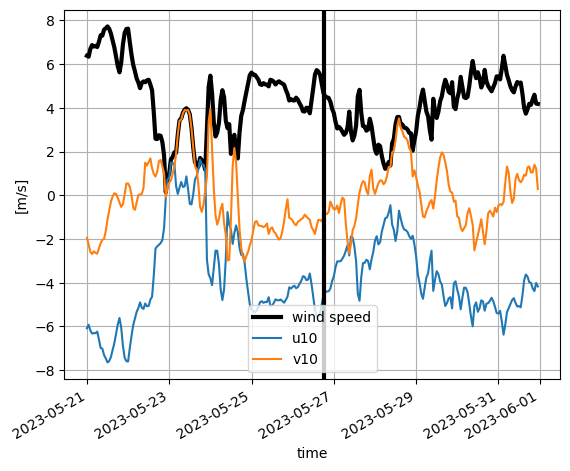

In [29]:
cycle_number = 533
pass_number = info["passes"][0]

D = sd.load_l2_core("Unsmoothed", pass_number, cycle_number) # , extent=info["extent"]
t = D["left"].time.mean().values
print("variables: "+" / ".join(list(D["left"])))

delta = pd.Timedelta("5d")
_era5 = sd.load_era5(t-delta, t+delta, location=info["location"])

plot_wind_tseries_small(_era5)

In [33]:
#plot_l2(D, "ssh_karin_2", pass_number, cycle_number, mask_threshold=1, vmin=-.2, vmax=.2, lat_bounds=[0, 5])

In [ ]:
plot_l2(D, "sig0_karin_2", pass_number, cycle_number, mask_threshold=20, vmin=1., vmax=2.)

---

## Maluku Sea

In [4]:
region = "maluku"
info = sd.regions[region]

# load wind
location = info["location"]
era5 = sd.load_era5("2023/04/01", "2023/07/15", location=location)

times = sd.get_times(info["coordinates"])

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40817 instead
  warnings.warn(


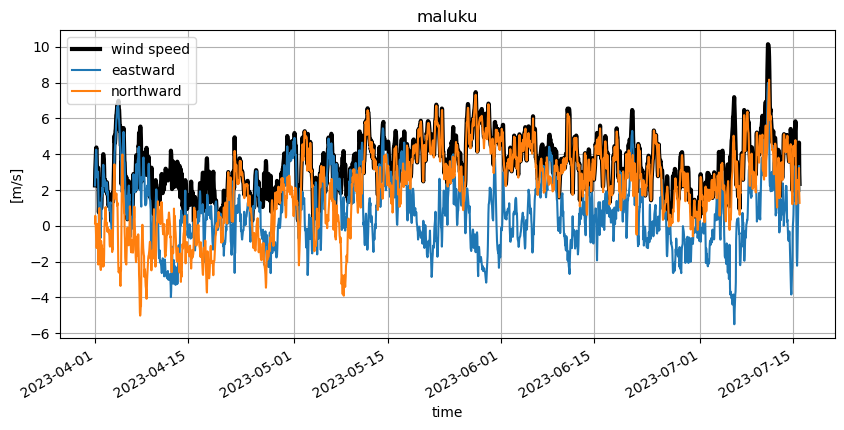

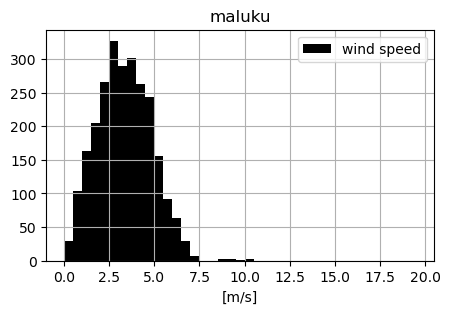

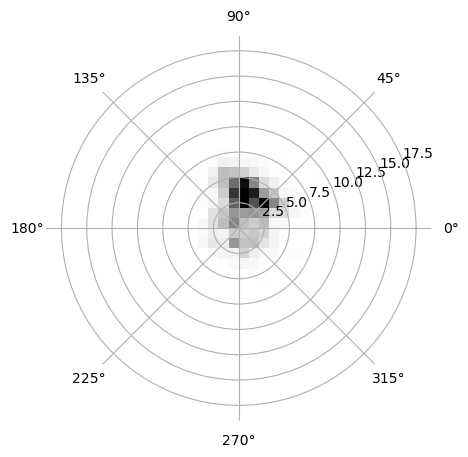

In [5]:
# show wind statistics
show_wind_teries(era5)
show_wind_hist(era5, np.arange(0,20,.5), np.arange(-20,20,1))

In [6]:
(era5["wind_speed"].hvplot(grid=True)*era5["u10"].hvplot()*era5["v10"].hvplot())

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Overlay
   .Curve.I   :Curve   [time]   (wind_speed)
   .Curve.II  :Curve   [time]   (u10)
   .Curve.III :Curve   [time]   (v10)

In [7]:
times.set_index("time")["cycle"].hvplot(grid=True)

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Curve   [time]   (cycle)

variables: time / time_tai / latitude_uncert / longitude_uncert / polarization_karin / ssh_karin_2 / ssh_karin_2_qual / ssh_karin_uncert / sig0_karin_2 / sig0_karin_2_qual / sig0_karin_uncert / total_coherence / mean_sea_surface_cnescls / miti_power_250m / miti_power_var_250m / ancillary_surface_classification_flag / tan_theta / sig0_karin_2_raw / ssh_karin_2_low / ssh_karin_2_high / sig0_karin_2_low / sig0_karin_2_high


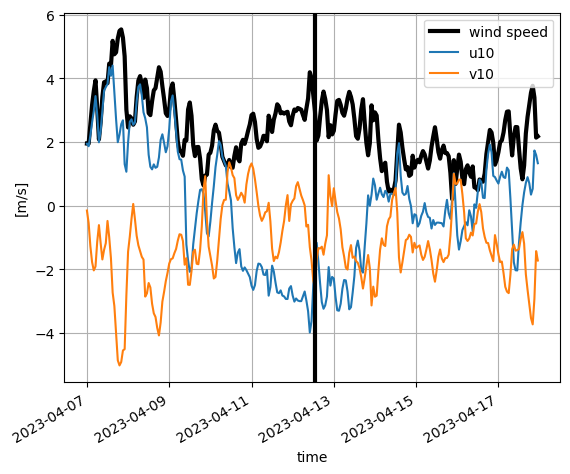

In [15]:
cycle_number = 486 # little sigma0 signature
cycle_number = 487 # clear ssh signature near sigma0 bright spot
cycle_number = 488 # ?
pass_number = info["passes"][0]

D = sd.load_l2_core("Unsmoothed", pass_number, cycle_number, extent=info["extent"], preprocessing=add_filtered_fields)
t = D["left"].time.mean().values
print("variables: "+" / ".join(list(D["left"])))

delta = pd.Timedelta("5d")
_era5 = sd.load_era5(t-delta, t+delta, location=info["location"])

plot_wind_tseries_small(_era5)

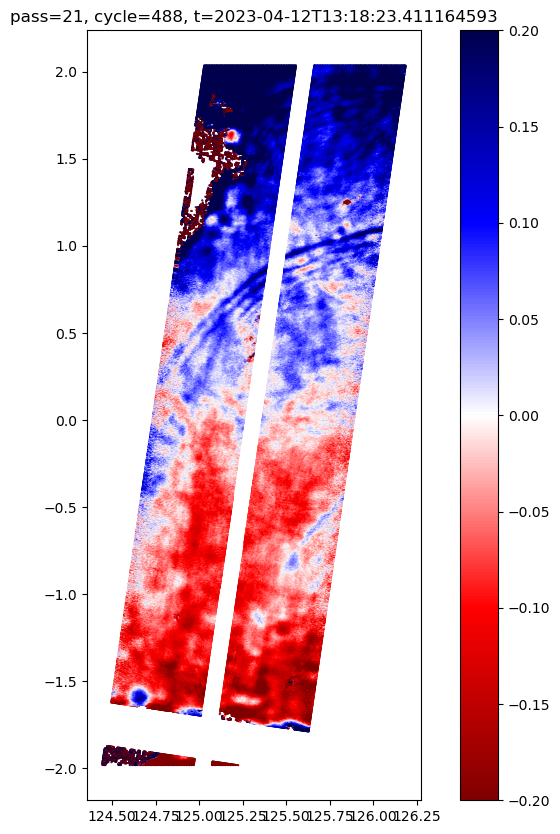

In [16]:
plot_l2(D, "ssh_karin_2", pass_number, cycle_number, mask_threshold=10, vmin=-.2, vmax=.2)
# lat_bounds=[0, 5]

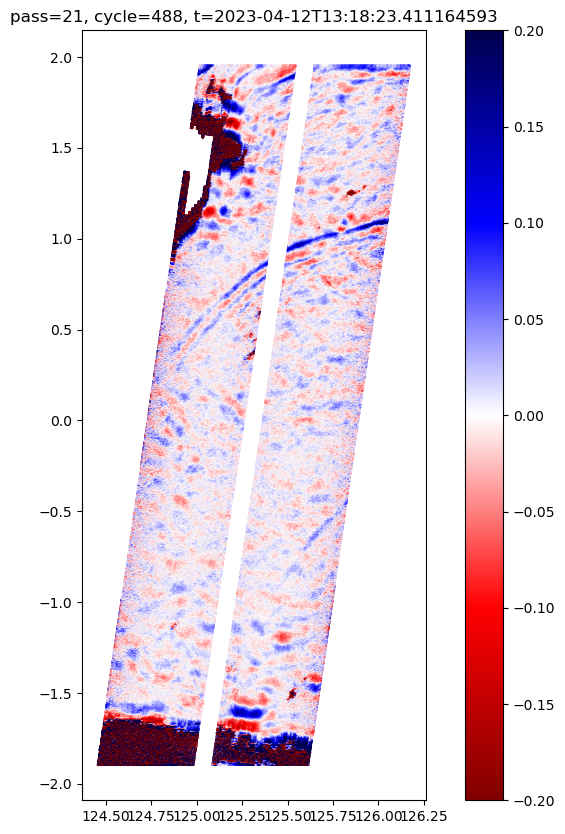

In [17]:
plot_l2(D, "ssh_karin_2_high", pass_number, cycle_number, mask_threshold=None, vmin=-.2, vmax=.2, cmap="seismic_r")

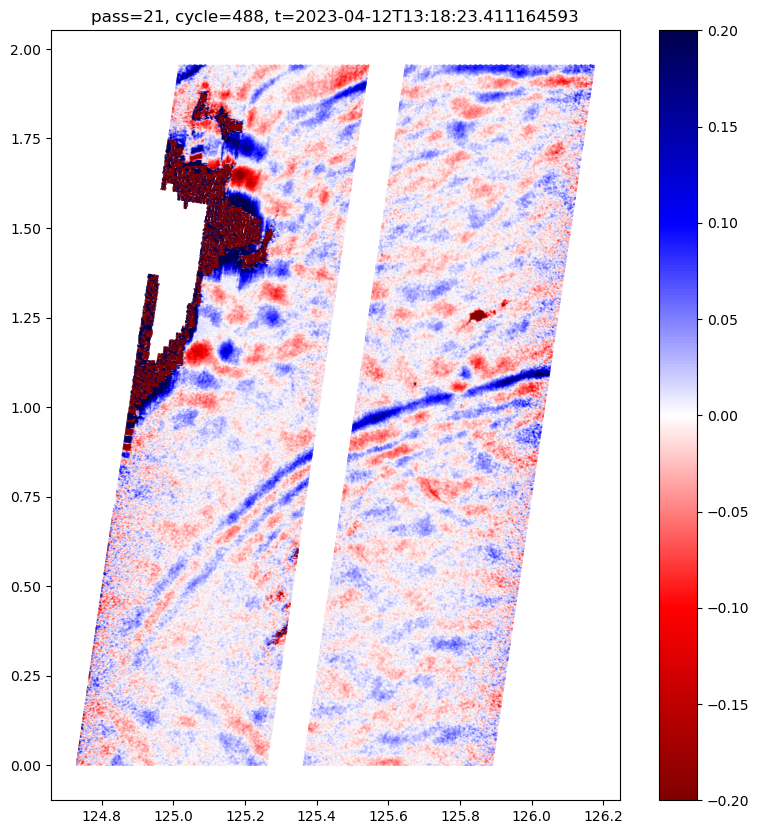

In [18]:
plot_l2(D, "ssh_karin_2_high", pass_number, cycle_number, mask_threshold=None, vmin=-.2, vmax=.2, cmap="seismic_r", lat_bounds=[0,2])

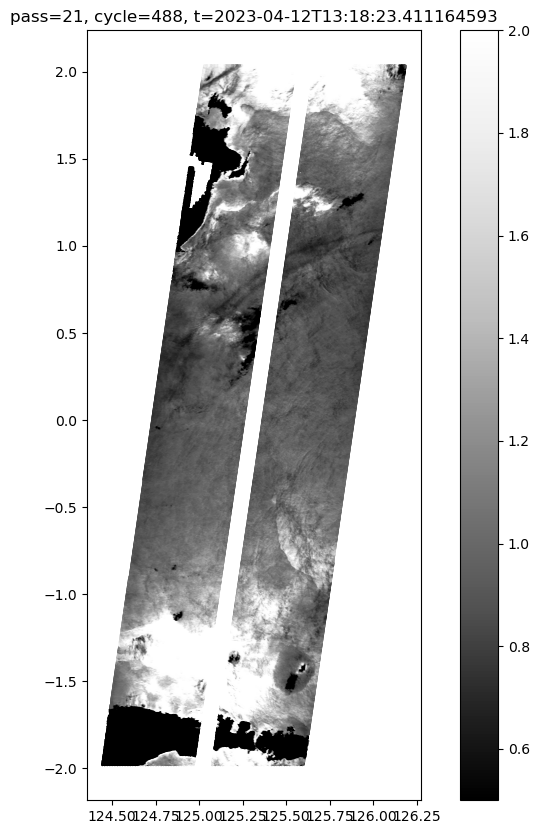

In [24]:
s0_bounds = dict(vmin=0.5, vmax=2.)
plot_l2(D, "sig0_karin_2", pass_number, cycle_number, mask_threshold=None, **s0_bounds)

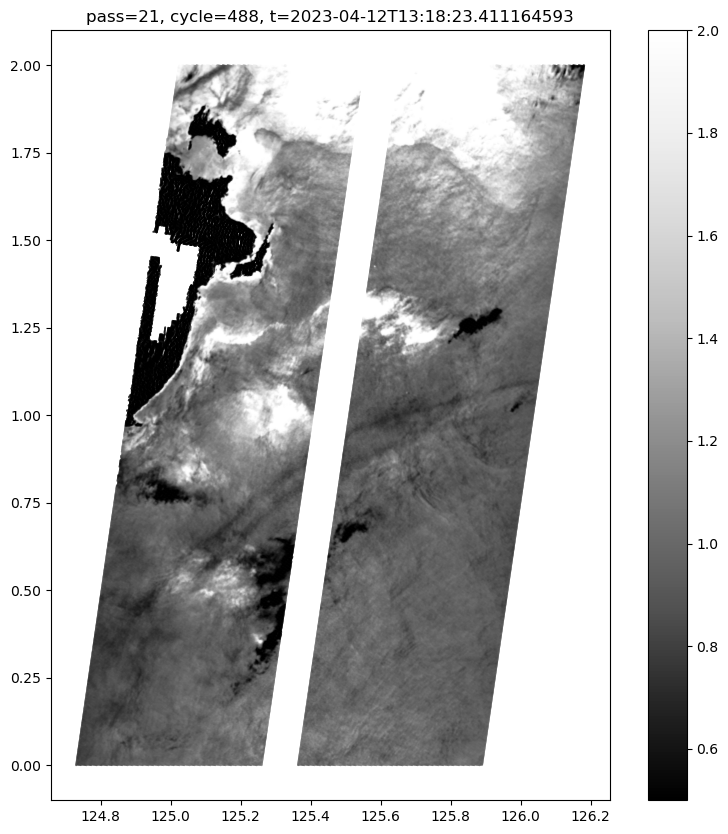

In [25]:
plot_l2(D, "sig0_karin_2", pass_number, cycle_number, mask_threshold=None, lat_bounds=[0,2], **s0_bounds)

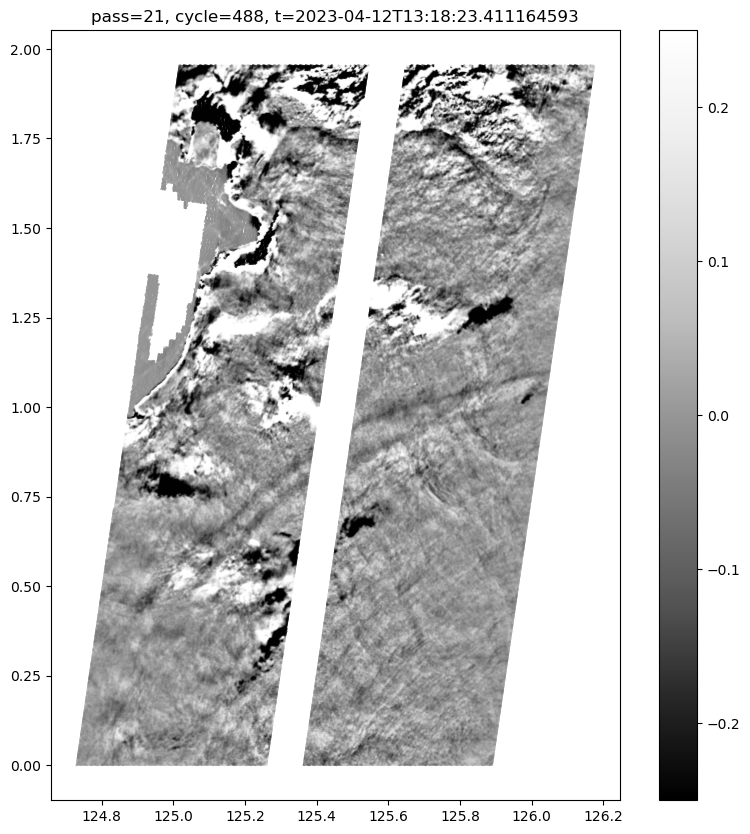

In [28]:
plot_l2(D, "sig0_karin_2_high", pass_number, cycle_number, mask_threshold=None, cmap="Greys_r", 
        vmin=-0.25, vmax=0.25, lat_bounds=[0,2])

---

## cross-track sigma0 sensitivity

In [6]:
cycle_number = 500
pass_number = 20

D = sd.load_l2_core("Unsmoothed", pass_number, cycle_number)

In [15]:
da = D["left"]["sig0_karin_2"]
da

<xarray.DataArray 'sig0_karin_2' (num_lines: 82346, num_pixels: 240)>
[19763040 values with dtype=float32]
Coordinates:
    latitude   (num_lines, num_pixels) float64 ...
    longitude  (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels
Attributes:
    long_name:      normalized radar cross section (sigma0) from KaRIn
    standard_name:  surface_backwards_scattering_coefficient_of_radar_wave
    units:          1
    quality_flag:   sig0_karin_2_qual
    valid_min:      -1000.0
    valid_max:      10000000.0
    comment:        Normalized radar cross section (sigma0) from KaRIn in rea...

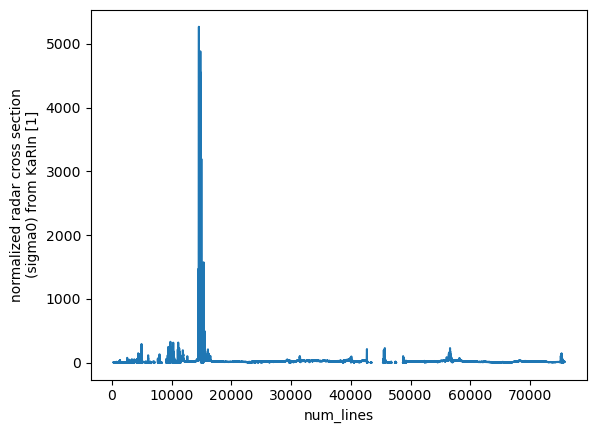

In [16]:
da.isel(num_pixels=10).plot()

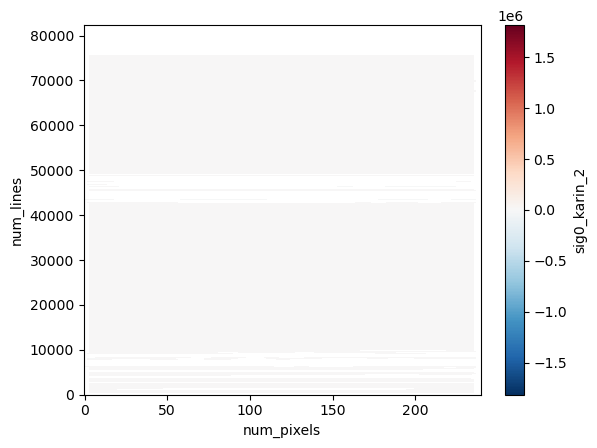

In [17]:
(da/da.isel(num_pixels=10)).plot()

Expected cross-track sensitivity:

$
\begin{align}
\sigma_0 &\propto 1/mss \times \exp ( -\tan^2 (\theta) /mss), \\
\log(\sigma_0(\theta=0)) &\propto \log(1/mss) \\
\log(\sigma_0) &\propto \log(\sigma_0(0)) - \tan^2 (\theta) \times 1/mss, \\
\sigma_0/\sigma_{0} &\propto \exp ( -\tan^2 (\theta) /mss), \\
\log \sigma_0/\sigma_0(0) &\propto -(\tan^2 (\theta) \times \sigma_0(0), \\
\frac{\log (\sigma_0/\sigma_0(0))}{\sigma_0(0)} &\propto -\tan^2 (\theta), \\
mss &= 5\times10^{-3} \times u10
\end{align}
$




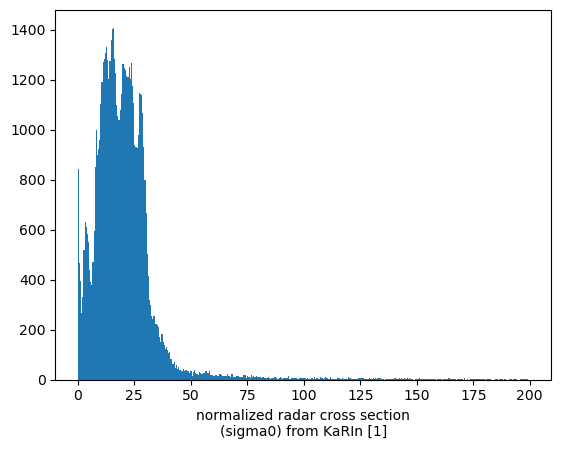

In [28]:
da.isel(num_pixels=10).plot.hist(bins=np.arange(0,200,.5));

In [45]:
# .6 to 4
np.tan(np.deg2rad(4))**2

0.00488975902858307

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


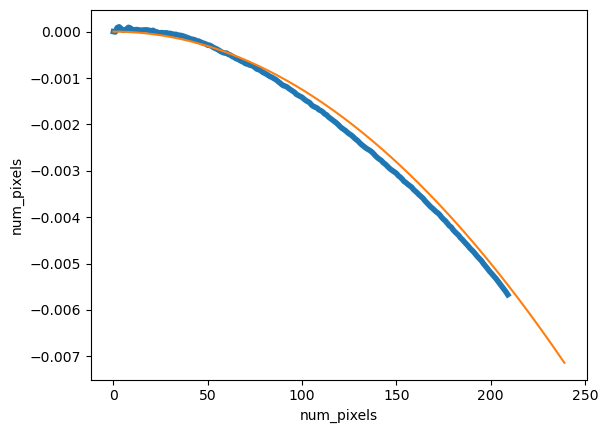

In [43]:
s0 = da
s00 = da.isel(num_pixels=10)
fig, ax = plt.subplots(1,1)
(np.log10(s0/s00)/s00).median("num_lines")[10:220].plot(ax=ax, lw=4)
(-5e-3*(da.num_pixels/200)**2).plot(ax=ax)

In [ ]:
ds = D["left"]

from scipy.optimize import least_squares

i = 200
_ds = ds.isel(num_lines=i)
sig0 = _ds.sig0_karin_2.values
tan_theta = _ds.tan_theta.values
#sig0, tan_theta

# get rid of nans
tan_theta = tan_theta[np.where(~np.isnan(sig0))]
sig0 = sig0[np.where(~np.isnan(sig0))]

def fun(x):
    # sig0 = cst / mss * exp(-tan_theta**2/mss)
    # x = [cst, ]
    return sig0 - fun_sig0(x[0], x[1])

def fun_sig0(cst, mss):
    return cst/mss*np.exp(-tan_theta**2/mss)

mss0 = 0.04
x0 = np.array([sig0[0]*mss0*np.exp(tan_theta[0]**2/mss0), mss0])
print(x0)

# https://scipy-cookbook.readthedocs.io/items/robust_regression.html
res_robust = least_squares(fun, x0, loss='soft_l1')    
cst, mss = res_robust["x"] # cst, mss

fig, ax = plt.subplots(1,1)
ax.plot(sig0)
ax.plot(fun_sig0(cst, mss))
ax.set_title(f"sig0, mss={mss:.2e}, cst={cst:.2e}")

def fit_mss(sig0, tan_theta):

    # get rid of nans
    tan_theta = tan_theta[np.where(~np.isnan(sig0))]
    sig0 = sig0[np.where(~np.isnan(sig0))]
    if sig0.size==0:
        return 0

    def fun(x):
        # sig0 = cst / mss * exp(-tan_theta**2/mss)
        # x = [cst, ]
        return sig0 - fun_sig0(x[0], x[1])

    def fun_sig0(cst, mss):
        return cst/mss*np.exp(-tan_theta**2/mss)

    mss0 = 0.04
    x0 = np.array([sig0[0]*mss0*np.exp(tan_theta[0]**2/mss0), mss0])

    # https://scipy-cookbook.readthedocs.io/items/robust_regression.html
    res_robust = least_squares(fun, x0, loss='soft_l1')    
    cst, mss = res_robust["x"] # cst, mss
    
    return mss
    
da = xr.apply_ufunc(
    fit_mss, ds.sig0_karin_2_low, ds.tan_theta, 
    input_core_dims=[("num_pixels",), ("num_pixels",)], 
    vectorize=True,
)

In [70]:
theta = np.linspace(.6,4.1,50)
u10 = np.linspace(1,10,50)
ds = xr.Dataset(None, 
    coords=dict(u10=('u10', u10),
                theta=('theta', theta),
               )
)
ds["mss"] = 5e-3 * ds.u10
ds["_theta"] = np.deg2rad(ds.theta) # rad
ds["tan_theta"] = np.tan(ds._theta)
ds["sig0"] = 1/ds.mss * np.exp(-ds.tan_theta**2/ds.mss)
ds["exp"] = np.exp(-ds.tan_theta**2/ds.mss)

ds = ds.set_coords(["tan_theta"])

In [43]:
ds["sig0"].max()

<xarray.DataArray 'sig0' ()>
array(195.6609489)

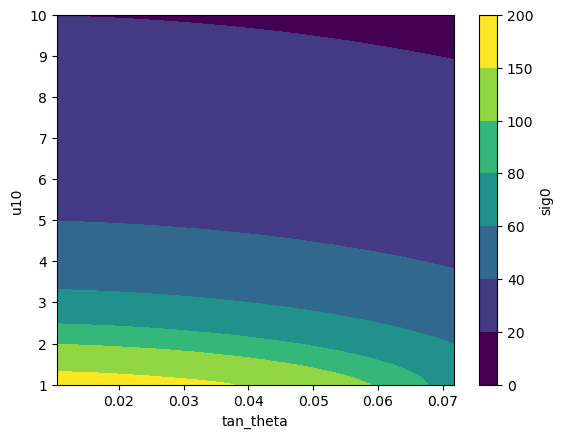

In [60]:
fig, ax = plt.subplots(1,1)
ds["sig0"].plot.contourf(x="tan_theta", y="u10", ax=ax, levels=np.array([0, 20, 40, 60, 80, 100, 150, 200]))
ax.set_title("sigma0")
#ax.set_yscale("log")

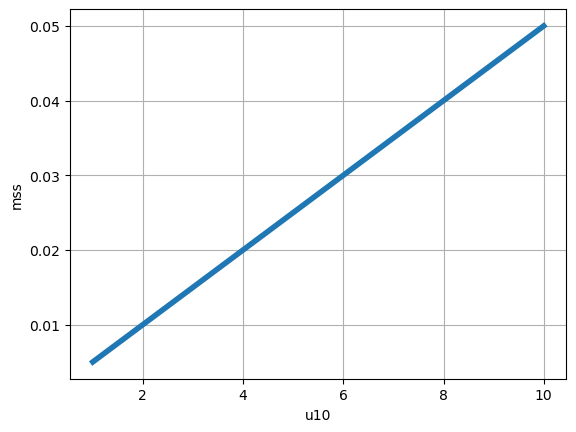

In [96]:
fig, ax = plt.subplots(1,1)

ds.mss.plot(lw=4)

#ds["sig0"].plot.contourf(ax=ax, levels=np.array([0, 20, 40, 60, 80, 100, 150, 200]))
#ax.set_yscale("log")

ax.grid()

(0.0, 204.54165555042178)

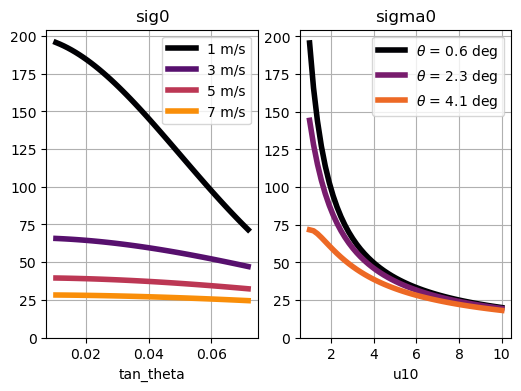

In [94]:
fig, axes = plt.subplots(1,2, figsize=(6,4))

ax = axes[0]
_lvls = [1, 3, 5, 7]
colors = plt.cm.inferno(np.linspace(0,1,len(_lvls)+1))
for u10, c in zip(_lvls, colors):
    _ds = ds.sel(u10=u10, method="nearest")
    _ds["sig0"].plot(x="tan_theta", ax=ax, color=c, lw=4, label=f"{u10} m/s")
ax.grid()
ax.set_title("sig0")
ax.legend()
ax.set_ylabel("")
ax.set_ylim(0,None)
#ds["sig0"].plot.contourf(ax=ax, levels=np.array([0, 20, 40, 60, 80, 100, 150, 200]))
#ax.set_yscale("log")


ax = axes[1]

_lvls = np.linspace(ds.theta.min(), ds.theta.max(), 3)
colors = plt.cm.inferno(np.linspace(0,1,len(_lvls)+1))
for t, c in zip(_lvls, colors):
    _ds = ds.sel(theta=t, method="nearest")
    _ds["sig0"].plot(ax=ax, color=c, lw=4, label=r"$\theta$ = "+f"{t:.1f} deg")
ax.grid()
ax.set_title("sigma0")
ax.legend()
ax.set_ylabel("")
ax.set_ylim(0,None)

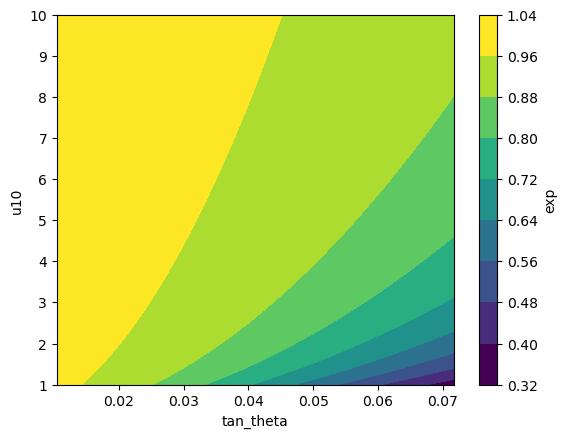

In [73]:
ds["exp"].plot.contourf(x="tan_theta", levels=10)

(0.0, 1.0288507758289216)

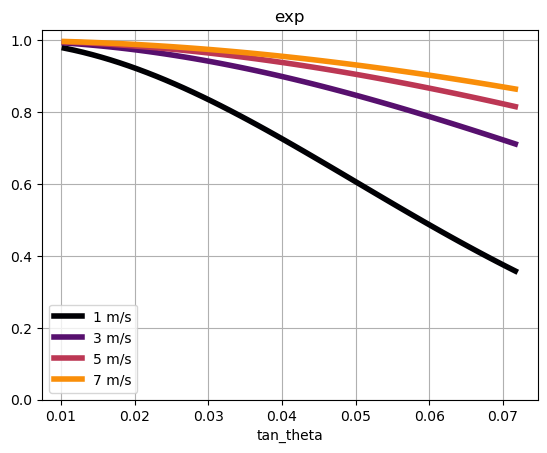

In [75]:
fig, ax = plt.subplots(1,1)

_lvls = [1, 3, 5, 7]
colors = plt.cm.inferno(np.linspace(0,1,len(_lvls)+1))
for u10, c in zip(_lvls, colors):
    _ds = ds.sel(u10=u10, method="nearest")
    _ds["exp"].plot(x="tan_theta", ax=ax, color=c, lw=4, label=f"{u10} m/s")
ax.grid()
ax.set_title("exp")
ax.legend()
ax.set_ylabel("")
ax.set_ylim(0,None)
#ds["sig0"].plot.contourf(ax=ax, levels=np.array([0, 20, 40, 60, 80, 100, 150, 200]))
#ax.set_yscale("log")

---

In [ ]:
client.close()
cluster.close()